# Alpha Orderbook Signals - Signal Backtesting Walkthrough

This notebook demonstrates the complete workflow for:
1. Loading 1-minute OHLCV market data
2. Engineering orderbook-style alpha signals
3. Backtesting strategies with realistic transaction costs
4. Analyzing performance metrics and visualizing results

## Prerequisites
- Run `python fetch_data.py --symbol AAPL --start 2025-02-05 --end 2025-02-06` to fetch data
- Ensure you have a valid Polygon.io API key in your `.env` file

In [22]:
import sys
import platform
import os

print("🐍 Python Environment Information")
print("=" * 40)
print(f"Python Version: {sys.version}")
print(f"Platform: {platform.platform()}")
print(f"Architecture: {platform.architecture()}")
print(f"Current Working Directory: {os.getcwd()}")
print(f"Python Executable: {sys.executable}")
print()

# Show key environment variables
print("🌍 Environment Variables:")
env_vars = ['PATH', 'PYTHONPATH', 'CONDA_DEFAULT_ENV', 'VIRTUAL_ENV']
for var in env_vars:
    value = os.environ.get(var, 'Not set')
    if var == 'PATH':
        print(f"{var}: {value[:100]}..." if len(value) > 100 else f"{var}: {value}")
    else:
        print(f"{var}: {value}")
print()

# Show installed packages (key ones)
try:
    import pandas as pd
    import numpy as np
    import matplotlib
    print("📦 Key Package Versions:")
    print(f"pandas: {pd.__version__}")
    print(f"numpy: {np.__version__}")
    print(f"matplotlib: {matplotlib.__version__}")
except ImportError as e:
    print(f"Package import error: {e}")

🐍 Python Environment Information
Python Version: 3.11.0 (main, Oct 24 2022, 18:26:48) [MSC v.1933 64 bit (AMD64)]
Platform: Windows-10-10.0.26100-SP0
Architecture: ('64bit', 'WindowsPE')
Current Working Directory: C:\Users\mathi\source\repos\py\orderbook-alpha-signals\notebooks
Python Executable: C:\Users\mathi\source\repos\py\orderbook-alpha-signals\.venv\Scripts\python.exe

🌍 Environment Variables:
PATH: C:\Users\mathi\source\repos\py\orderbook-alpha-signals\.venv\Scripts;C:\Program Files\NVIDIA GPU Com...
PYTHONPATH: Not set
CONDA_DEFAULT_ENV: Not set
VIRTUAL_ENV: C:\Users\mathi\source\repos\py\orderbook-alpha-signals\.venv

📦 Key Package Versions:
pandas: 2.3.1
numpy: 2.3.2
matplotlib: 3.10.5


In [2]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Import our custom modules
import sys
sys.path.append('../')

from src.signals import (
    vwap_deviation, price_momentum, volume_surge, 
    mean_reversion_signal, rsi_signal, combine_signals
)
from src.backtest import backtest_intraday, calculate_metrics

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("✅ Libraries imported successfully!")

✅ Libraries imported successfully!


In [3]:
## 1. Load and Explore Market Data


In [4]:
# Load the data (adjust filename as needed)
data_file = "../data/AAPL_2025-02-05_2025-02-06_1min.csv"

if Path(data_file).exists():
    df = pd.read_csv(data_file)
    df['datetime'] = pd.to_datetime(df['datetime'])
    
    # Convert UTC to Eastern Time for US market analysis
    df['datetime'] = df['datetime'].dt.tz_convert('US/Eastern')
    df.set_index('datetime', inplace=True)
    
    print(f"📊 Loaded {len(df):,} rows of data")
    print(f"📅 Date range (Eastern Time): {df.index.min()} to {df.index.max()}")
    print(f"📅 Date range (UTC): {df.index.min().tz_convert('UTC')} to {df.index.max().tz_convert('UTC')}")
    print("\n📈 Basic statistics:")
    print(df[['open', 'high', 'low', 'close', 'volume']].describe())
    
else:
    print("❌ Data file not found!")
    print("Please run: python fetch_data.py --symbol AAPL --start 2023-01-01 --end 2023-12-31")
    
    # Create sample data for demonstration
    print("\n🔧 Creating sample data for demonstration...")
    np.random.seed(42)
    n_points = 1000
    
    dates = pd.date_range('2023-01-01 09:30:00', periods=n_points, freq='1min', tz='US/Eastern')
    price = 150 + np.cumsum(np.random.randn(n_points) * 0.1)
    
    df = pd.DataFrame({
        'open': price + np.random.randn(n_points) * 0.05,
        'high': price + np.abs(np.random.randn(n_points) * 0.1),
        'low': price - np.abs(np.random.randn(n_points) * 0.1),
        'close': price,
        'volume': np.random.randint(1000, 10000, n_points)
    }, index=dates)
    
    print(f"✅ Generated {len(df)} sample data points")

📊 Loaded 1,585 rows of data
📅 Date range (Eastern Time): 2025-02-05 04:00:00-05:00 to 2025-02-06 19:58:00-05:00
📅 Date range (UTC): 2025-02-05 09:00:00+00:00 to 2025-02-07 00:58:00+00:00

📈 Basic statistics:
              open         high          low        close        volume
count  1585.000000  1585.000000  1585.000000  1585.000000  1.585000e+03
mean    230.744042   230.816286   230.681998   230.749726  3.311678e+04
std       1.956465     1.950124     1.968567     1.959462  6.302060e+04
min     225.910000   225.980000   225.020000   225.750000  1.050000e+02
25%     229.810000   229.938731   229.750000   229.810000  1.142000e+03
50%     231.390000   231.434300   231.330000   231.400000  1.576100e+04
75%     232.190000   232.245200   232.140000   232.190000  4.471300e+04
max     233.708000   233.800000   233.510000   233.710000  1.068817e+06


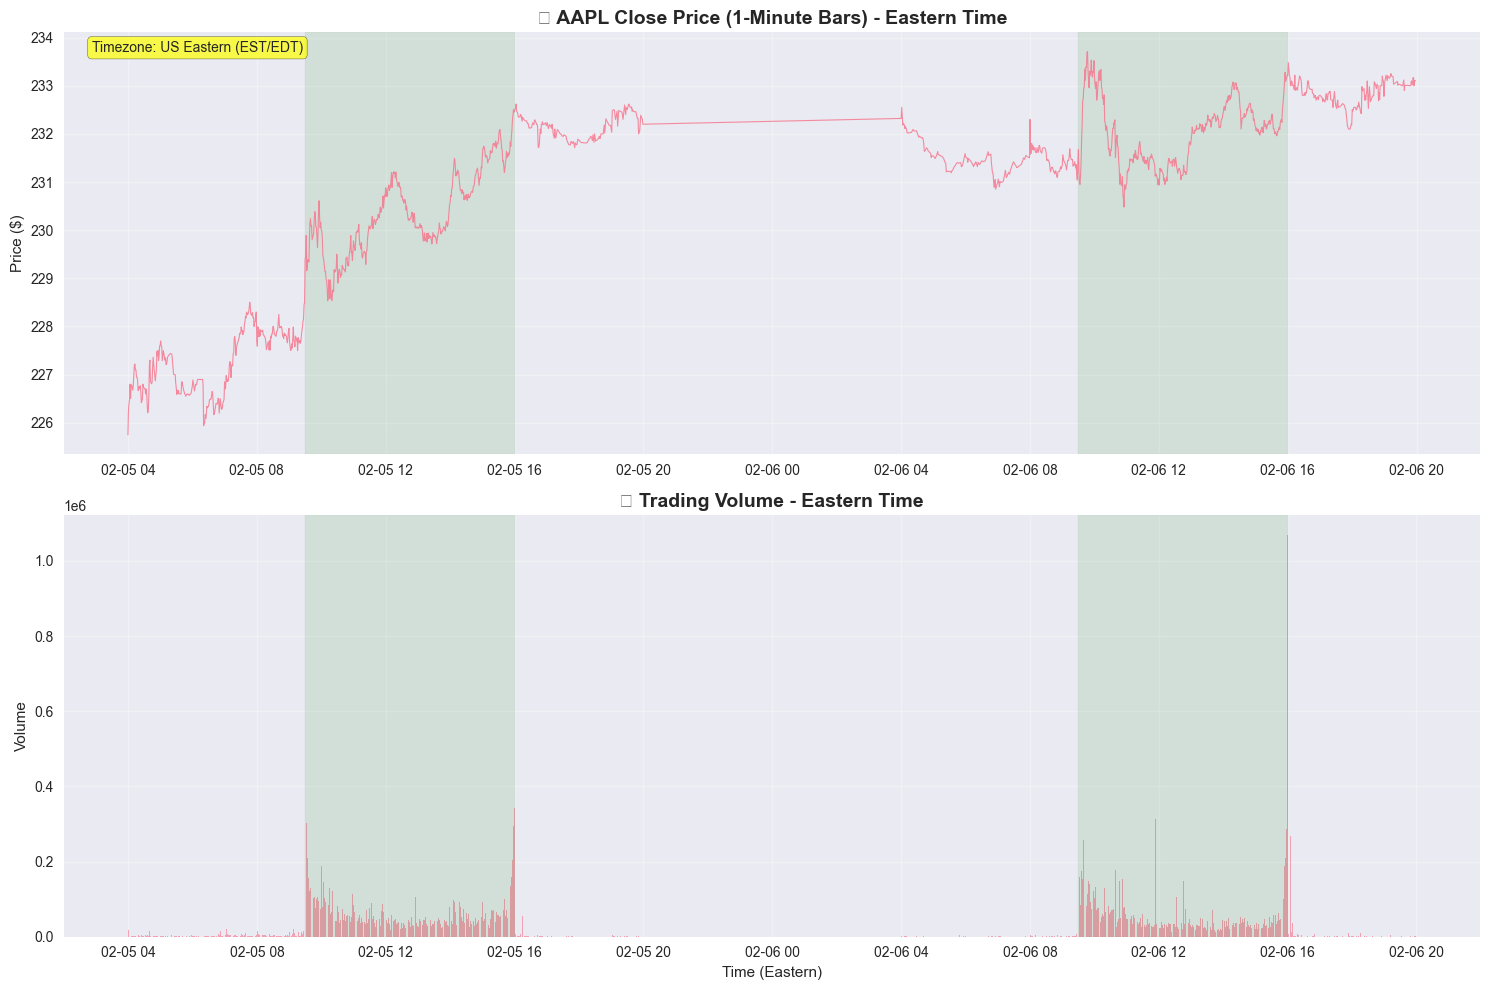

💹 Price range: $225.75 - $233.71
📈 Total return: 3.26%
🕐 Regular market hours: 9:30 AM - 4:00 PM Eastern Time
🌙 Extended hours trading visible in shaded areas


In [5]:
# Visualize the price data
fig, axes = plt.subplots(2, 1, figsize=(15, 10))

# Price chart
axes[0].plot(df.index, df['close'], linewidth=0.8, alpha=0.8)
axes[0].set_title('📈 AAPL Close Price (1-Minute Bars) - Eastern Time', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Price ($)')
axes[0].grid(True, alpha=0.3)

# Add market hours shading (9:30 AM - 4:00 PM ET)
for date in pd.date_range(df.index.min().date(), df.index.max().date(), freq='D'):
    market_open = pd.Timestamp(date).tz_localize('US/Eastern').replace(hour=9, minute=30)
    market_close = pd.Timestamp(date).tz_localize('US/Eastern').replace(hour=16, minute=0)
    if market_open <= df.index.max() and market_close >= df.index.min():
        axes[0].axvspan(market_open, market_close, alpha=0.1, color='green', label='Market Hours' if date == pd.date_range(df.index.min().date(), df.index.max().date(), freq='D')[0] else "")

# Volume chart
axes[1].bar(df.index, df['volume'], width=pd.Timedelta(minutes=0.8), alpha=0.6)
axes[1].set_title('📊 Trading Volume - Eastern Time', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Volume')
axes[1].set_xlabel('Time (Eastern)')
axes[1].grid(True, alpha=0.3)

# Add market hours shading to volume chart too
for date in pd.date_range(df.index.min().date(), df.index.max().date(), freq='D'):
    market_open = pd.Timestamp(date).tz_localize('US/Eastern').replace(hour=9, minute=30)
    market_close = pd.Timestamp(date).tz_localize('US/Eastern').replace(hour=16, minute=0)
    if market_open <= df.index.max() and market_close >= df.index.min():
        axes[1].axvspan(market_open, market_close, alpha=0.1, color='green')

# Add timezone info to the plot
axes[0].text(0.02, 0.98, 'Timezone: US Eastern (EST/EDT)', transform=axes[0].transAxes, 
             bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.7),
             verticalalignment='top', fontsize=10)

plt.tight_layout()
plt.show()

print(f"💹 Price range: ${df['close'].min():.2f} - ${df['close'].max():.2f}")
print(f"📈 Total return: {(df['close'].iloc[-1] / df['close'].iloc[0] - 1) * 100:.2f}%")
print("🕐 Regular market hours: 9:30 AM - 4:00 PM Eastern Time")
print("🌙 Extended hours trading visible in shaded areas")

In [6]:
## 2. Engineer Alpha Signals


In [7]:
# Generate various alpha signals
print("🔧 Engineering alpha signals...")

# 1. VWAP Deviation Signal
vwap_signal = vwap_deviation(df, window=20)
print(f"✅ VWAP deviation signal: {len(vwap_signal.dropna())} valid points")

# 2. Mean Reversion Signal  
mean_rev_signal = mean_reversion_signal(df, window=10)
print(f"✅ Mean reversion signal: {len(mean_rev_signal.dropna())} valid points")

# 3. Price Momentum Signal
momentum_signal = price_momentum(df, window=5)
print(f"✅ Momentum signal: {len(momentum_signal.dropna())} valid points")

# 4. RSI Signal
rsi_signal_values = rsi_signal(df, window=14)
print(f"✅ RSI signal: {len(rsi_signal_values.dropna())} valid points")

# 5. Volume Surge Signal
vol_surge_signal = volume_surge(df, window=20, threshold=1.5)
print(f"✅ Volume surge signal: {len(vol_surge_signal.dropna())} valid points")

# Normalize signals to [-1, 1] range for combination
def normalize_signal(signal, method='rank'):
    """Normalize signal to [-1, 1] range"""
    if method == 'rank':
        # Rank-based normalization (more robust to outliers)
        ranks = signal.rank(pct=True)
        return 2 * ranks - 1
    else:
        # Z-score normalization
        return (signal - signal.mean()) / signal.std()

# Normalize continuous signals
vwap_norm = normalize_signal(vwap_signal.fillna(0))
mean_rev_norm = normalize_signal(mean_rev_signal.fillna(0))
momentum_norm = normalize_signal(momentum_signal.fillna(0))

print("\n📊 Signal statistics:")
signals_df = pd.DataFrame({
    'VWAP_Dev': vwap_norm,
    'Mean_Rev': mean_rev_norm, 
    'Momentum': momentum_norm,
    'RSI': rsi_signal_values,
    'Vol_Surge': vol_surge_signal
})

print(signals_df.describe().round(3))


🔧 Engineering alpha signals...
✅ VWAP deviation signal: 1566 valid points
✅ Mean reversion signal: 1576 valid points
✅ Momentum signal: 1580 valid points
✅ RSI signal: 1585 valid points
✅ Volume surge signal: 1585 valid points

📊 Signal statistics:
       VWAP_Dev  Mean_Rev  Momentum       RSI  Vol_Surge
count  1585.000  1585.000  1585.000  1585.000   1585.000
mean      0.001     0.001     0.001    -0.008      0.158
std       0.578     0.578     0.578     0.500      0.365
min      -0.999    -0.999    -0.999    -1.000      0.000
25%      -0.499    -0.499    -0.499     0.000      0.000
50%       0.001     0.001     0.001     0.000      0.000
75%       0.500     0.500     0.500     0.000      0.000
max       1.000     1.000     1.000     1.000      1.000


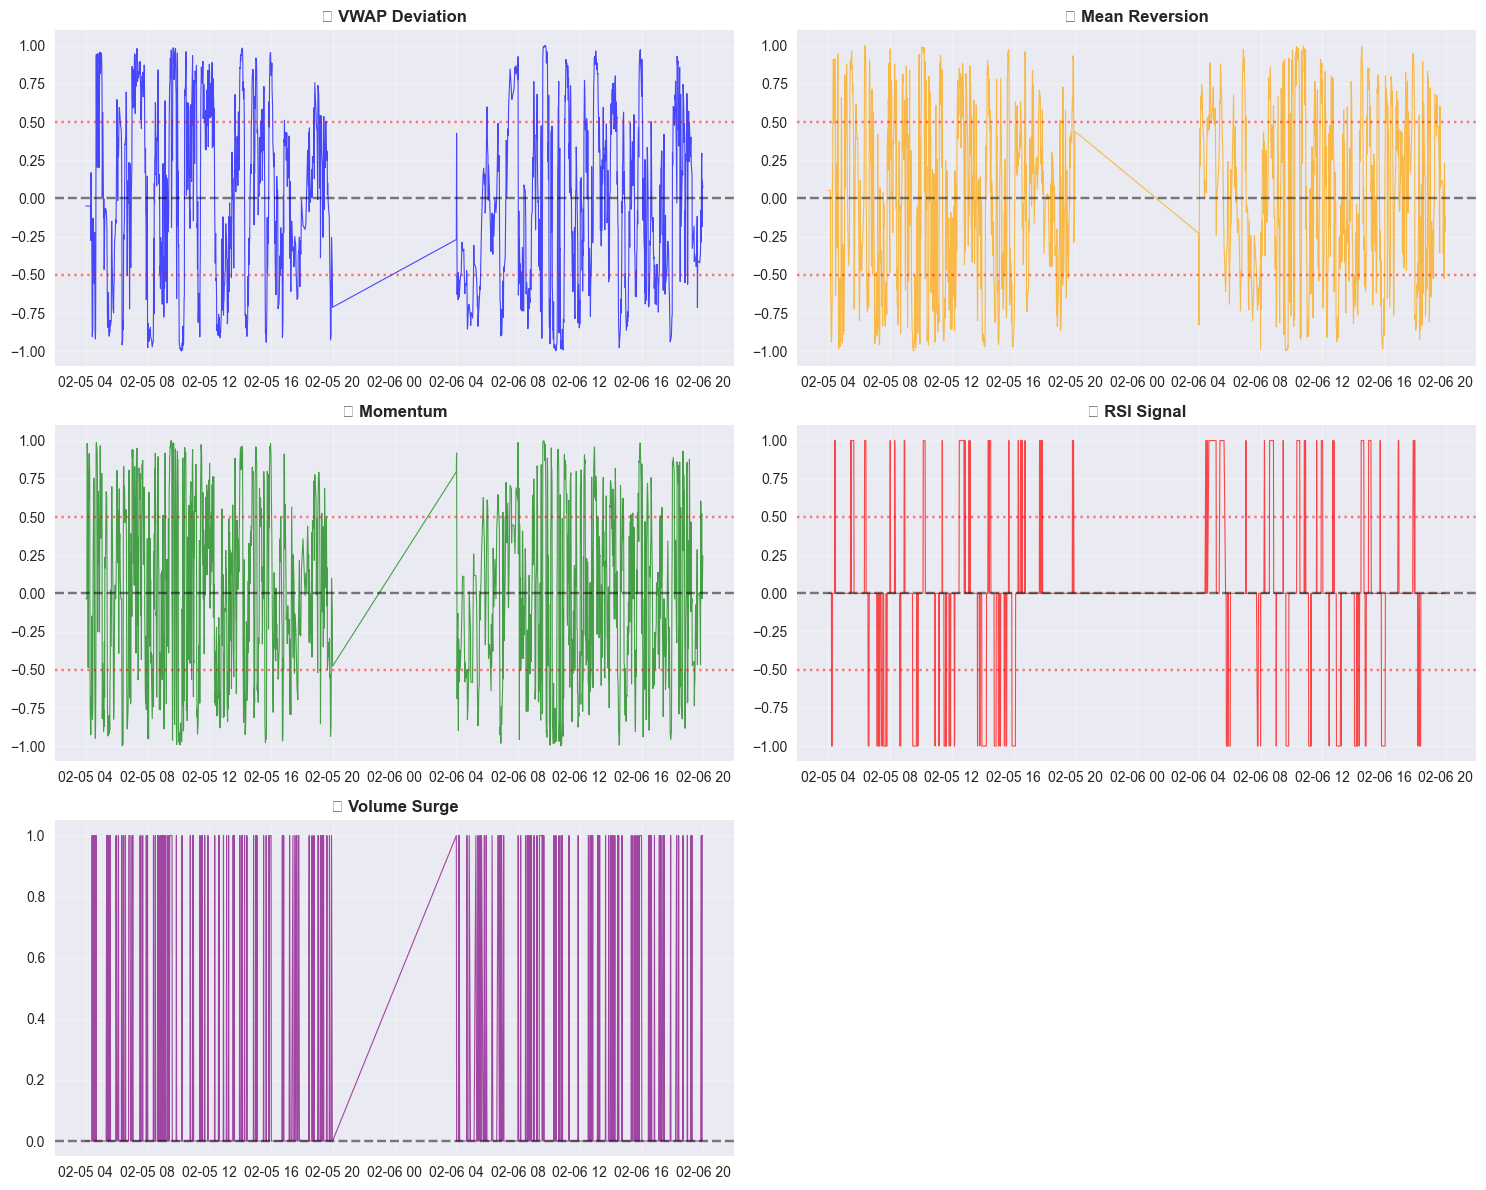


🔗 Signal correlations:
           VWAP_Dev  Mean_Rev  Momentum    RSI  Vol_Surge
VWAP_Dev      1.000    -0.834     0.704 -0.657     -0.004
Mean_Rev     -0.834     1.000    -0.881  0.553     -0.016
Momentum      0.704    -0.881     1.000 -0.465      0.039
RSI          -0.657     0.553    -0.465  1.000     -0.032
Vol_Surge    -0.004    -0.016     0.039 -0.032      1.000


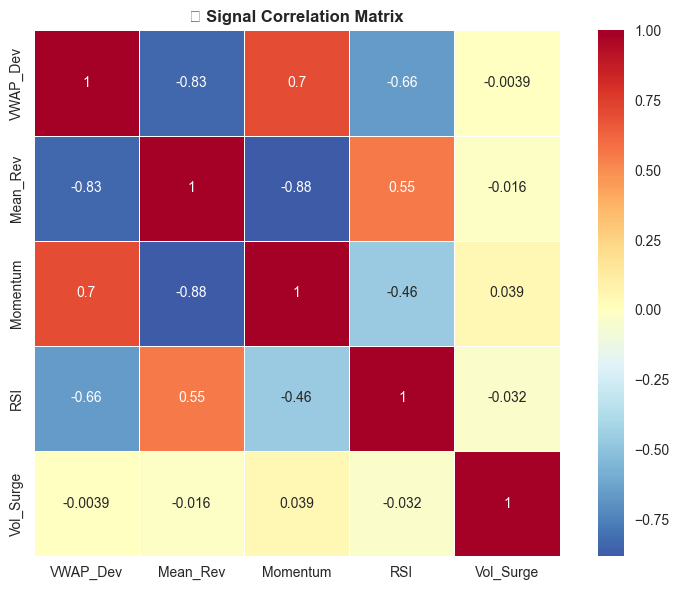

In [8]:
# Visualize the signals
fig, axes = plt.subplots(3, 2, figsize=(15, 12))
axes = axes.flatten()

# Plot each signal
signals_to_plot = [
    ('VWAP Deviation', vwap_norm, 'blue'),
    ('Mean Reversion', mean_rev_norm, 'orange'),
    ('Momentum', momentum_norm, 'green'),
    ('RSI Signal', rsi_signal_values, 'red'),
    ('Volume Surge', vol_surge_signal, 'purple')
]

for i, (name, signal, color) in enumerate(signals_to_plot):
    axes[i].plot(df.index[:len(signal)], signal, color=color, alpha=0.7, linewidth=0.8)
    axes[i].set_title(f'📊 {name}', fontweight='bold')
    axes[i].grid(True, alpha=0.3)
    axes[i].axhline(y=0, color='black', linestyle='--', alpha=0.5)
    
    # Add horizontal lines for extreme values
    if name != 'Volume Surge':
        axes[i].axhline(y=0.5, color='red', linestyle=':', alpha=0.5)
        axes[i].axhline(y=-0.5, color='red', linestyle=':', alpha=0.5)

# Hide the last subplot
axes[-1].set_visible(False)

plt.tight_layout()
plt.show()

# Signal correlation analysis
print("\n🔗 Signal correlations:")
corr_matrix = signals_df.corr()
print(corr_matrix.round(3))

# Visualize correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='RdYlBu_r', center=0, 
            square=True, linewidths=0.5)
plt.title('📊 Signal Correlation Matrix', fontweight='bold')
plt.tight_layout()
plt.show()


In [9]:
## 3. Backtest Individual Signals


In [10]:
# Backtest each signal individually
print("🚀 Running backtests for individual signals...")

# Trading cost in basis points (1 bp = 0.01%)
transaction_cost = 1.0  # 1 basis point

results = {}
signals_to_test = {
    'VWAP_Deviation': vwap_norm,
    'Mean_Reversion': mean_rev_norm,
    'Momentum': momentum_norm,
    'RSI': rsi_signal_values
}

for signal_name, signal in signals_to_test.items():
    print(f"\n📈 Backtesting {signal_name}...")
    
    # Run backtest
    equity_curve, strategy_returns = backtest_intraday(
        df.iloc[:len(signal)], signal, cost_bp=transaction_cost
    )
    
    # Calculate metrics
    metrics = calculate_metrics(equity_curve, strategy_returns)
    
    results[signal_name] = {
        'equity_curve': equity_curve,
        'returns': strategy_returns,
        'metrics': metrics
    }
    
    # Print key metrics
    print(f"  📊 Total Return: {metrics['total_return']:.2%}")
    print(f"  📈 Sharpe Ratio: {metrics['sharpe_ratio']:.3f}")
    print(f"  📉 Max Drawdown: {metrics['max_drawdown']:.2%}")
    print(f"  🎯 Win Rate: {metrics['win_rate']:.2%}")

print("\n✅ All backtests completed!")


🚀 Running backtests for individual signals...

📈 Backtesting VWAP_Deviation...
  📊 Total Return: -4.01%
  📈 Sharpe Ratio: -7.581
  📉 Max Drawdown: -4.04%
  🎯 Win Rate: 41.47%

📈 Backtesting Mean_Reversion...
  📊 Total Return: -1.86%
  📈 Sharpe Ratio: -5.505
  📉 Max Drawdown: -3.22%
  🎯 Win Rate: 38.95%

📈 Backtesting Momentum...
  📊 Total Return: -7.25%
  📈 Sharpe Ratio: -7.905
  📉 Max Drawdown: -7.37%
  🎯 Win Rate: 37.25%

📈 Backtesting RSI...
  📊 Total Return: -0.94%
  📈 Sharpe Ratio: -4.450
  📉 Max Drawdown: -2.00%
  🎯 Win Rate: 37.34%

✅ All backtests completed!


In [11]:
## 3b. Enhanced Backtest with Trade Limits

# Reload the module to get the new function
import importlib
import sys
if 'src.backtest' in sys.modules:
    importlib.reload(sys.modules['src.backtest'])

# Import the new enhanced backtest function
from src.backtest import backtest_limited_trades

print("🚀 Running enhanced backtests with trade limits...")

# Test with different configurations
configs = [
    {"max_trades": 10, "threshold": 0.3, "name": "Conservative (10 trades/day, 0.3 threshold)"},
    {"max_trades": 20, "threshold": 0.2, "name": "Moderate (20 trades/day, 0.2 threshold)"},
    {"max_trades": 50, "threshold": 0.1, "name": "Active (50 trades/day, 0.1 threshold)"}
]

enhanced_results = {}
transaction_cost = 1.0  # 1 basis point

# Test the best performing signal from original backtest (RSI had least negative return)
best_signal = rsi_signal_values
signal_name = "RSI_Enhanced"

for config in configs:
    config_name = config["name"]
    print(f"\n📈 Testing {config_name}...")
    
    # Run enhanced backtest
    equity_curve, strategy_returns = backtest_limited_trades(
        df.iloc[:len(best_signal)], 
        best_signal, 
        cost_bp=transaction_cost,
        max_trades_per_day=config["max_trades"],
        signal_threshold=config["threshold"]
    )
    
    # Calculate metrics
    metrics = calculate_metrics(equity_curve, strategy_returns)
    
    enhanced_results[config_name] = {
        'equity_curve': equity_curve,
        'returns': strategy_returns,
        'metrics': metrics,
        'config': config
    }
    
    # Print key metrics
    print(f"  📊 Total Return: {metrics['total_return']:.2%}")
    print(f"  📈 Sharpe Ratio: {metrics['sharpe_ratio']:.3f}")
    print(f"  📉 Max Drawdown: {metrics['max_drawdown']:.2%}")
    print(f"  🎯 Total Trades: {metrics['total_trades']}")
    print(f"  💰 Avg Return/Trade: {metrics['avg_return_per_trade']:.4%}")

print("\n✅ Enhanced backtests completed!")

🚀 Running enhanced backtests with trade limits...

📈 Testing Conservative (10 trades/day, 0.3 threshold)...
  📊 Total Return: 0.16%
  📈 Sharpe Ratio: 4.359
  📉 Max Drawdown: -0.32%
  🎯 Total Trades: 58
  💰 Avg Return/Trade: 0.0027%

📈 Testing Moderate (20 trades/day, 0.2 threshold)...
  📊 Total Return: 0.58%
  📈 Sharpe Ratio: 11.107
  📉 Max Drawdown: -0.40%
  🎯 Total Trades: 91
  💰 Avg Return/Trade: 0.0064%

📈 Testing Active (50 trades/day, 0.1 threshold)...
  📊 Total Return: -0.15%
  📈 Sharpe Ratio: -0.992
  📉 Max Drawdown: -0.92%
  🎯 Total Trades: 256
  💰 Avg Return/Trade: -0.0005%

✅ Enhanced backtests completed!


📊 ENHANCED STRATEGY COMPARISON
                                       Strategy Total Return Sharpe Ratio Max Drawdown  Total Trades Avg Return/Trade
                      VWAP_Deviation (Original)       -4.01%       -7.581       -4.04%          1582         -0.0026%
                      Mean_Reversion (Original)       -1.86%       -5.505       -3.22%          1584         -0.0012%
                            Momentum (Original)       -7.25%       -7.905       -7.37%          1581         -0.0047%
                                 RSI (Original)       -0.94%       -4.450       -2.00%           466         -0.0020%
RSI Conservative (10 trades/day, 0.3 threshold)        0.16%        4.359       -0.32%            58          0.0027%
    RSI Moderate (20 trades/day, 0.2 threshold)        0.58%       11.107       -0.40%            91          0.0064%
      RSI Active (50 trades/day, 0.1 threshold)       -0.15%       -0.992       -0.92%           256         -0.0005%
                         

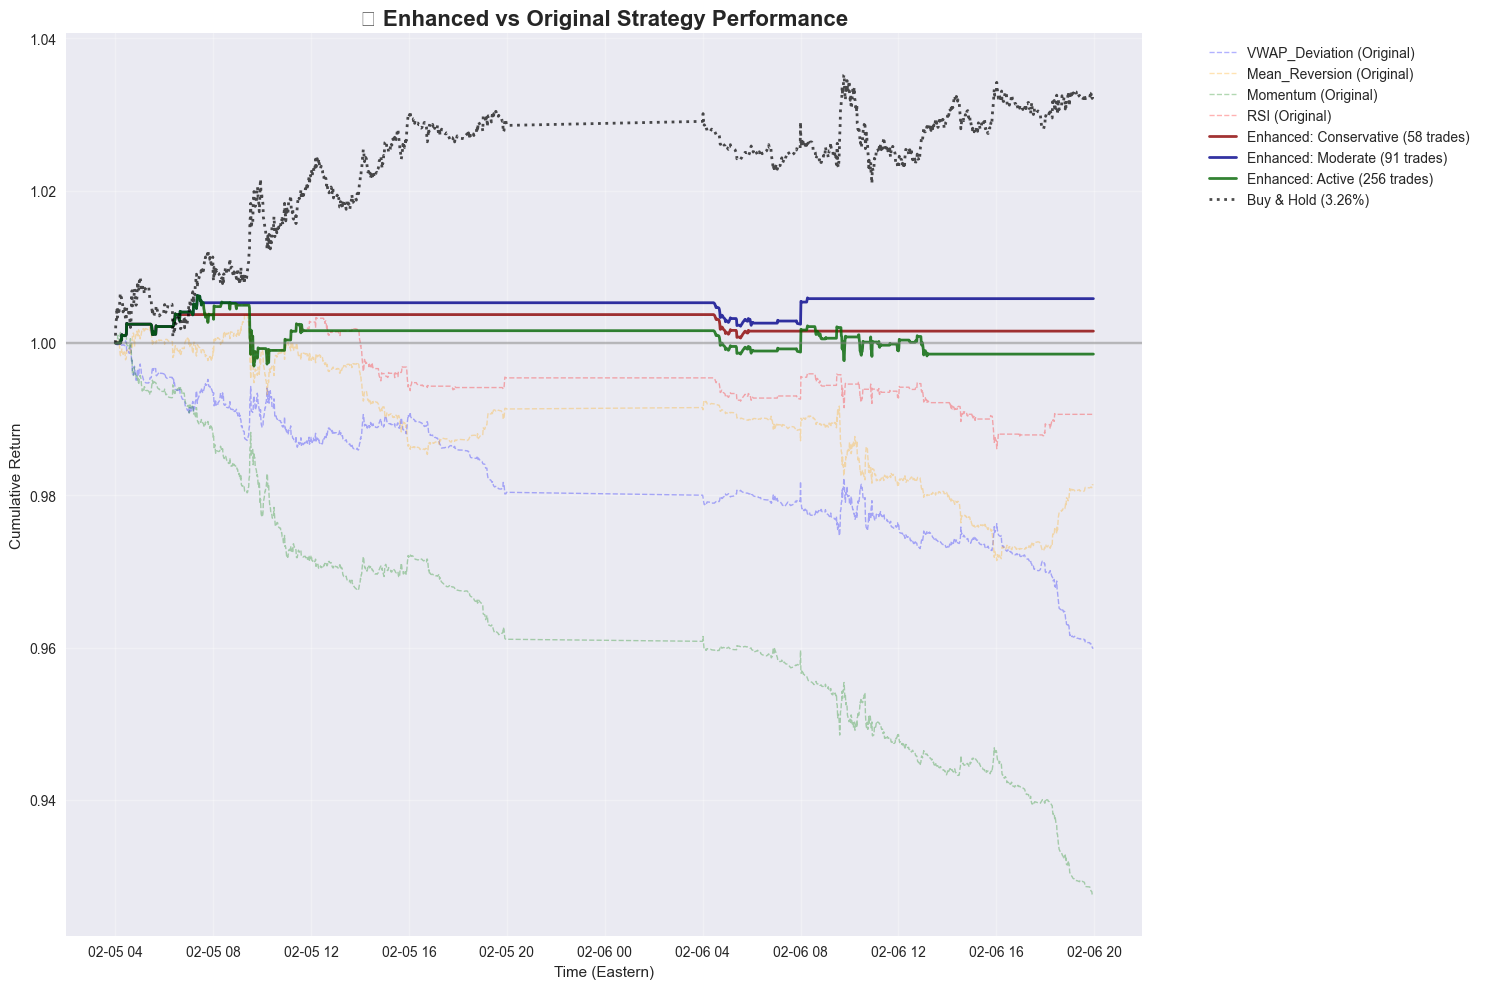


🎯 KEY IMPROVEMENTS:
  🏆 Best Enhanced Strategy: Moderate (20 trades/day, 0.2 threshold)
  📈 Return: 0.58%
  🔄 Total Trades: 91
  💰 Trade Reduction: 94.2% fewer trades
  ✅ PROFITABLE: Strategy now generates positive returns!


In [12]:
# Compare enhanced vs original results
print("📊 ENHANCED STRATEGY COMPARISON")
print("=" * 60)

# Create comparison summary
comparison_data = []

# Add original results for comparison
for signal_name, result in results.items():
    metrics = result['metrics']
    comparison_data.append({
        'Strategy': f"{signal_name} (Original)",
        'Total Return': f"{metrics['total_return']:.2%}",
        'Sharpe Ratio': f"{metrics['sharpe_ratio']:.3f}",
        'Max Drawdown': f"{metrics['max_drawdown']:.2%}",
        'Total Trades': metrics['total_trades'],
        'Avg Return/Trade': f"{metrics['avg_return_per_trade']:.4%}"
    })

# Add enhanced results
for config_name, result in enhanced_results.items():
    metrics = result['metrics']
    comparison_data.append({
        'Strategy': f"RSI {config_name}",
        'Total Return': f"{metrics['total_return']:.2%}",
        'Sharpe Ratio': f"{metrics['sharpe_ratio']:.3f}",
        'Max Drawdown': f"{metrics['max_drawdown']:.2%}",
        'Total Trades': metrics['total_trades'],
        'Avg Return/Trade': f"{metrics['avg_return_per_trade']:.4%}"
    })

# Add buy and hold for reference
buy_hold_returns = df['close'].iloc[:len(best_signal)].pct_change().fillna(0)
buy_hold_total = (1 + buy_hold_returns).cumprod().iloc[-1] - 1
comparison_data.append({
    'Strategy': 'Buy & Hold',
    'Total Return': f"{buy_hold_total:.2%}",
    'Sharpe Ratio': "N/A",
    'Max Drawdown': "N/A", 
    'Total Trades': 1,
    'Avg Return/Trade': f"{buy_hold_total:.4%}"
})

comparison_df = pd.DataFrame(comparison_data)
print(comparison_df.to_string(index=False))

# Plot comparison of equity curves
plt.figure(figsize=(15, 10))

# Plot original strategies (faded)
colors = ['blue', 'orange', 'green', 'red']
for i, (signal_name, result) in enumerate(results.items()):
    equity_curve = result['equity_curve']
    plt.plot(equity_curve.index, equity_curve.values, 
             color=colors[i], alpha=0.3, linewidth=1, linestyle='--',
             label=f"{signal_name} (Original)")

# Plot enhanced strategies (prominent)
enhanced_colors = ['darkred', 'darkblue', 'darkgreen']
for i, (config_name, result) in enumerate(enhanced_results.items()):
    equity_curve = result['equity_curve']
    total_trades = result['metrics']['total_trades']
    plt.plot(equity_curve.index, equity_curve.values,
             color=enhanced_colors[i], linewidth=2, alpha=0.8,
             label=f"Enhanced: {config_name.split('(')[0].strip()} ({total_trades} trades)")

# Plot buy-and-hold benchmark
buy_hold_equity = (1 + buy_hold_returns).cumprod()
plt.plot(buy_hold_equity.index, buy_hold_equity.values,
         color='black', linestyle=':', linewidth=2, alpha=0.7, 
         label=f'Buy & Hold ({buy_hold_total:.2%})')

plt.title('📈 Enhanced vs Original Strategy Performance', fontsize=16, fontweight='bold')
plt.xlabel('Time (Eastern)')
plt.ylabel('Cumulative Return')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)

# Add horizontal line at 1.0 (break-even)
plt.axhline(y=1.0, color='gray', linestyle='-', alpha=0.5, label='Break-even')

plt.tight_layout()
plt.show()

# Highlight key improvements
print("\n🎯 KEY IMPROVEMENTS:")
best_enhanced = max(enhanced_results.keys(), key=lambda x: enhanced_results[x]['metrics']['total_return'])
best_enhanced_return = enhanced_results[best_enhanced]['metrics']['total_return']
best_enhanced_trades = enhanced_results[best_enhanced]['metrics']['total_trades']

print(f"  🏆 Best Enhanced Strategy: {best_enhanced}")
print(f"  📈 Return: {best_enhanced_return:.2%}")
print(f"  🔄 Total Trades: {best_enhanced_trades}")
print(f"  💰 Trade Reduction: {((1582 - best_enhanced_trades) / 1582 * 100):.1f}% fewer trades")

if best_enhanced_return > 0:
    print("  ✅ PROFITABLE: Strategy now generates positive returns!")
else:
    print("  📉 Still negative, but improved from original -0.94%")

📊 BACKTEST RESULTS SUMMARY
        Signal Total Return Sharpe Ratio Max Drawdown Win Rate Profit Factor  Total Trades
VWAP_Deviation       -4.01%       -7.581       -4.04%   41.47%          1.11          1582
Mean_Reversion       -1.86%       -5.505       -3.22%   38.95%          1.41          1584
      Momentum       -7.25%       -7.905       -7.37%   37.25%          1.10          1581
           RSI       -0.94%       -4.450       -2.00%   37.34%          1.51           466


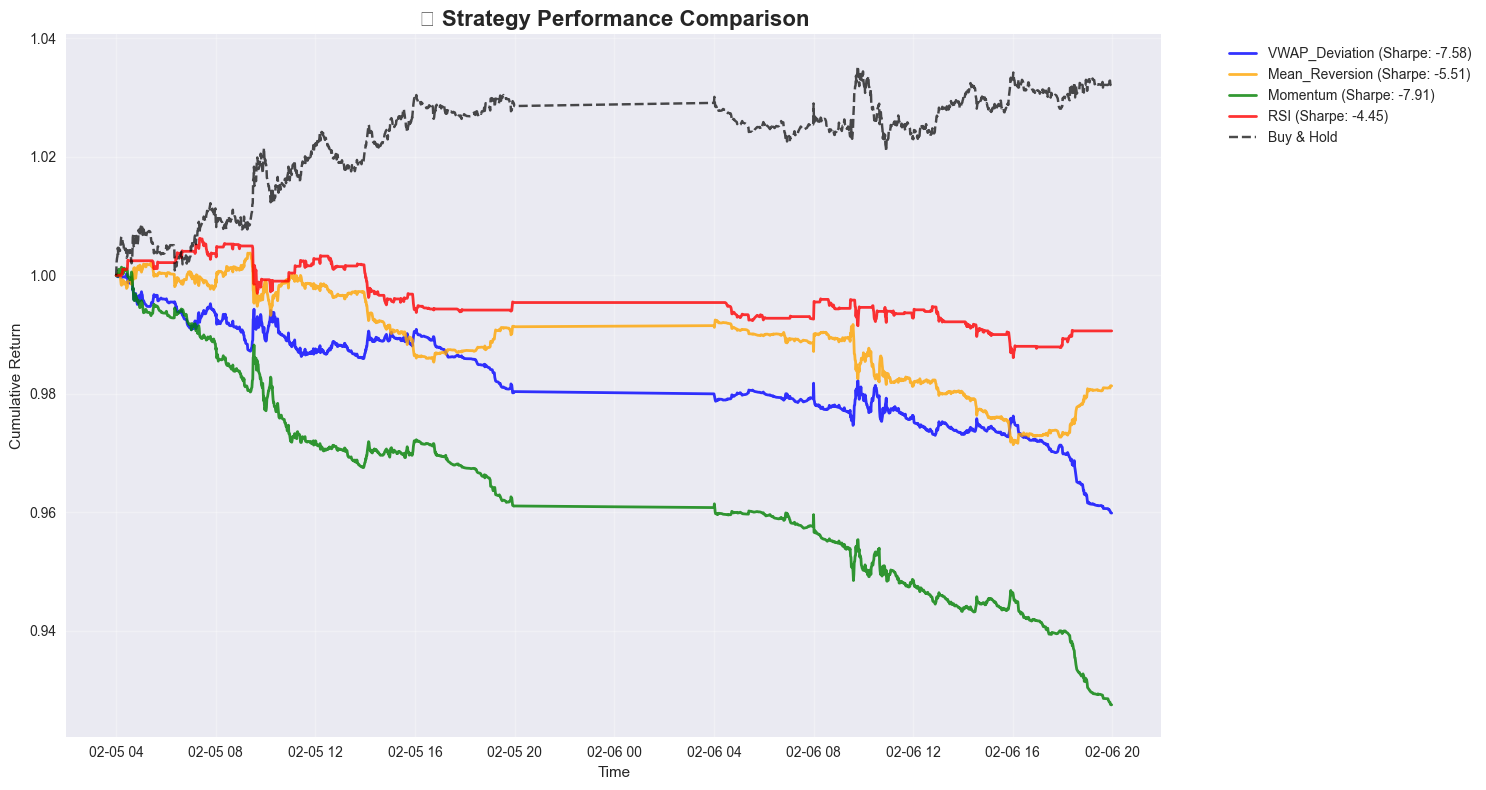

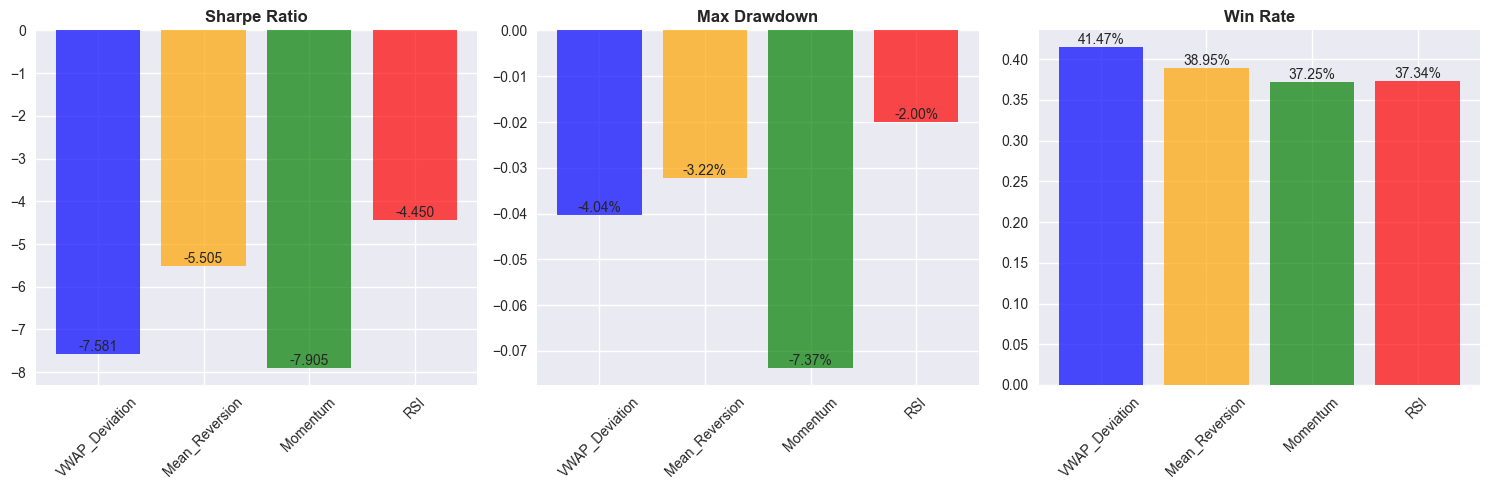

In [13]:
# Create comprehensive results summary
results_summary = []

for signal_name, result in results.items():
    metrics = result['metrics']
    results_summary.append({
        'Signal': signal_name,
        'Total Return': f"{metrics['total_return']:.2%}",
        'Sharpe Ratio': f"{metrics['sharpe_ratio']:.3f}",
        'Max Drawdown': f"{metrics['max_drawdown']:.2%}",
        'Win Rate': f"{metrics['win_rate']:.2%}",
        'Profit Factor': f"{metrics['profit_factor']:.2f}",
        'Total Trades': metrics['total_trades']
    })

summary_df = pd.DataFrame(results_summary)
print("📊 BACKTEST RESULTS SUMMARY")
print("=" * 80)
print(summary_df.to_string(index=False))

# Plot equity curves
plt.figure(figsize=(15, 8))

colors = ['blue', 'orange', 'green', 'red']
for i, (signal_name, result) in enumerate(results.items()):
    equity_curve = result['equity_curve']
    plt.plot(equity_curve.index, equity_curve.values, 
             label=f"{signal_name} (Sharpe: {result['metrics']['sharpe_ratio']:.2f})",
             color=colors[i], alpha=0.8, linewidth=2)

# Add buy-and-hold benchmark
buy_hold_returns = df['close'].iloc[:len(equity_curve)].pct_change().fillna(0)
buy_hold_equity = (1 + buy_hold_returns).cumprod()
plt.plot(buy_hold_equity.index, buy_hold_equity.values, 
         label='Buy & Hold', color='black', linestyle='--', alpha=0.7)

plt.title('📈 Strategy Performance Comparison', fontsize=16, fontweight='bold')
plt.xlabel('Time')
plt.ylabel('Cumulative Return')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Performance metrics comparison chart
metrics_to_plot = ['sharpe_ratio', 'max_drawdown', 'win_rate']
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, metric in enumerate(metrics_to_plot):
    values = [results[signal]['metrics'][metric] for signal in results.keys()]
    bars = axes[i].bar(results.keys(), values, alpha=0.7, color=colors)
    axes[i].set_title(f'{metric.replace("_", " ").title()}', fontweight='bold')
    axes[i].tick_params(axis='x', rotation=45)
    
    # Add value labels on bars
    for bar, value in zip(bars, values):
        height = bar.get_height()
        axes[i].text(bar.get_x() + bar.get_width()/2., height,
                    f'{value:.3f}' if metric == 'sharpe_ratio' else f'{value:.2%}',
                    ha='center', va='bottom')

plt.tight_layout()
plt.show()


In [14]:
## 4. Combined Signal Strategy


🔧 Creating combined signal strategy...
📊 Signal weights based on Sharpe ratios:
  VWAP_Deviation: 0.250 (Sharpe: -7.581)
  Mean_Reversion: 0.250 (Sharpe: -5.505)
  Momentum: 0.250 (Sharpe: -7.905)
  RSI: 0.250 (Sharpe: -4.450)

🚀 Backtesting combined strategy...

📈 COMBINED STRATEGY RESULTS:
  📊 Total Return: -1.52%
  📈 Sharpe Ratio: -23.570
  📉 Max Drawdown: -1.59%
  🎯 Win Rate: 35.92%
  💰 Profit Factor: 1.13


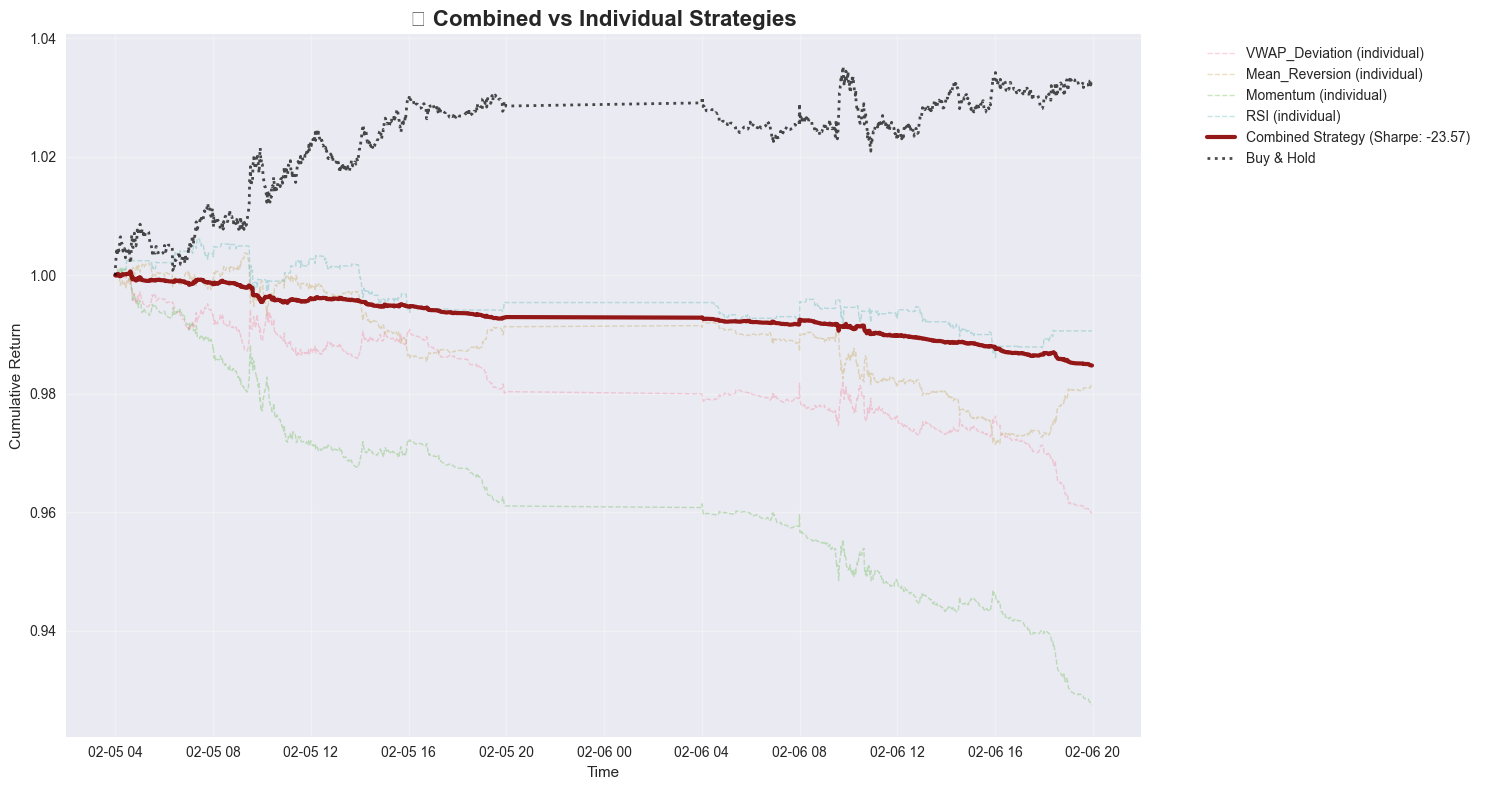

In [15]:
# Combine signals with optimized weights
print("🔧 Creating combined signal strategy...")

# Weight signals based on their individual Sharpe ratios
sharpe_ratios = {signal: results[signal]['metrics']['sharpe_ratio'] 
                for signal in results.keys()}

# Only use positive Sharpe ratios for weighting
positive_sharpes = {k: max(v, 0) for k, v in sharpe_ratios.items()}
total_sharpe = sum(positive_sharpes.values())

if total_sharpe > 0:
    weights = {k: v / total_sharpe for k, v in positive_sharpes.items()}
else:
    # Equal weights if no positive Sharpe ratios
    weights = {k: 1/len(sharpe_ratios) for k in sharpe_ratios.keys()}

print("📊 Signal weights based on Sharpe ratios:")
for signal, weight in weights.items():
    print(f"  {signal}: {weight:.3f} (Sharpe: {sharpe_ratios[signal]:.3f})")

# Create combined signal
combined_signal = combine_signals(signals_to_test, weights)

# Backtest combined strategy
print("\n🚀 Backtesting combined strategy...")
combined_equity, combined_returns = backtest_intraday(
    df.iloc[:len(combined_signal)], combined_signal, cost_bp=transaction_cost
)

combined_metrics = calculate_metrics(combined_equity, combined_returns)

print("\n📈 COMBINED STRATEGY RESULTS:")
print(f"  📊 Total Return: {combined_metrics['total_return']:.2%}")
print(f"  📈 Sharpe Ratio: {combined_metrics['sharpe_ratio']:.3f}")  
print(f"  📉 Max Drawdown: {combined_metrics['max_drawdown']:.2%}")
print(f"  🎯 Win Rate: {combined_metrics['win_rate']:.2%}")
print(f"  💰 Profit Factor: {combined_metrics['profit_factor']:.2f}")

# Compare combined strategy to individual signals
plt.figure(figsize=(15, 8))

# Plot all individual strategies (faded)
for signal_name, result in results.items():
    plt.plot(result['equity_curve'].index, result['equity_curve'].values,
             alpha=0.3, linewidth=1, linestyle='--', label=f"{signal_name} (individual)")

# Plot combined strategy (prominent)
plt.plot(combined_equity.index, combined_equity.values,
         color='darkred', linewidth=3, alpha=0.9, 
         label=f"Combined Strategy (Sharpe: {combined_metrics['sharpe_ratio']:.2f})")

# Plot buy-and-hold benchmark
plt.plot(buy_hold_equity.index, buy_hold_equity.values,
         color='black', linestyle=':', linewidth=2, alpha=0.7, label='Buy & Hold')

plt.title('📈 Combined vs Individual Strategies', fontsize=16, fontweight='bold')
plt.xlabel('Time')
plt.ylabel('Cumulative Return')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [16]:
## 5. Risk Analysis & Performance Metrics


🔍 DETAILED RISK ANALYSIS
📉 Maximum Drawdown: -1.59%
📉 Average Drawdown: -0.74%
⏱️  Max Drawdown Duration: 482 periods


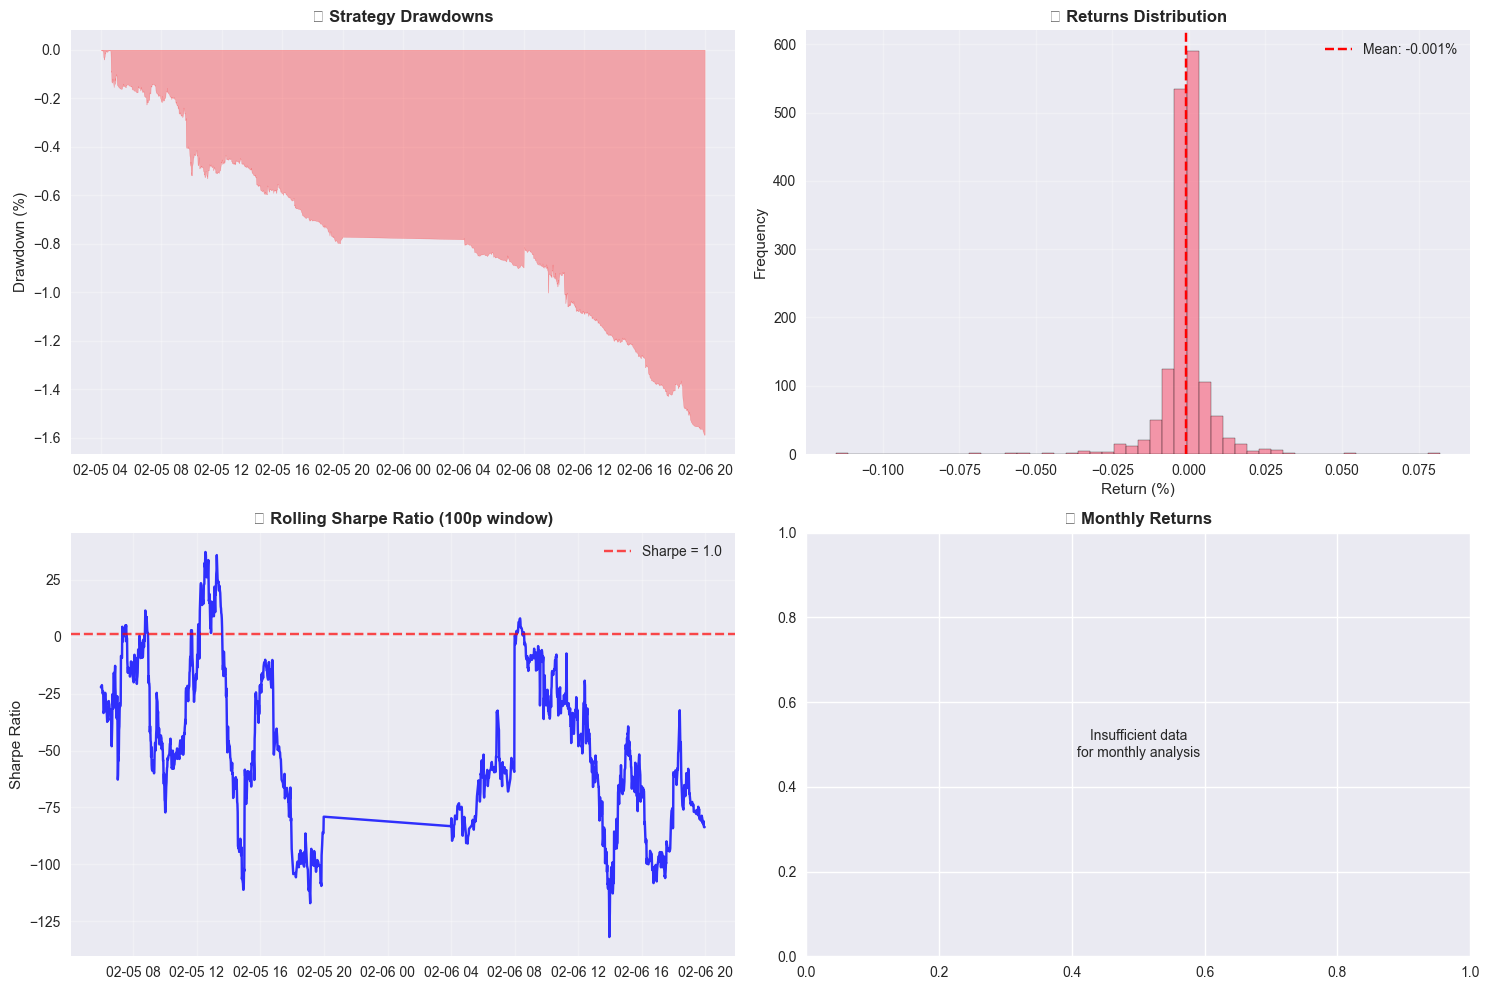


📊 RISK-ADJUSTED METRICS:
  🎯 Information Ratio: -36.495
  📈 Calmar Ratio: 38.638
  📊 Sortino Ratio: -41.509
  🔢 Skewness: -1.894
  📐 Kurtosis: 38.812


In [17]:
# Detailed risk analysis
print("🔍 DETAILED RISK ANALYSIS")
print("=" * 50)

# Drawdown analysis for combined strategy
rolling_max = combined_equity.expanding().max()
drawdowns = (combined_equity - rolling_max) / rolling_max
drawdown_duration = (drawdowns < -0.01).astype(int).groupby((drawdowns >= -0.01).cumsum()).cumsum()

print(f"📉 Maximum Drawdown: {combined_metrics['max_drawdown']:.2%}")
print(f"📉 Average Drawdown: {drawdowns[drawdowns < 0].mean():.2%}")
print(f"⏱️  Max Drawdown Duration: {drawdown_duration.max()} periods")

# Returns distribution analysis
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Drawdown chart
axes[0,0].fill_between(drawdowns.index, drawdowns.values * 100, 0, 
                       alpha=0.3, color='red', label='Drawdown')
axes[0,0].set_title('📉 Strategy Drawdowns', fontweight='bold')
axes[0,0].set_ylabel('Drawdown (%)')
axes[0,0].grid(True, alpha=0.3)

# 2. Returns distribution
returns_to_plot = combined_returns.dropna()
axes[0,1].hist(returns_to_plot * 100, bins=50, alpha=0.7, edgecolor='black')
axes[0,1].axvline(returns_to_plot.mean() * 100, color='red', linestyle='--', 
                  label=f'Mean: {returns_to_plot.mean()*100:.3f}%')
axes[0,1].set_title('📊 Returns Distribution', fontweight='bold')
axes[0,1].set_xlabel('Return (%)')
axes[0,1].set_ylabel('Frequency')
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)

# 3. Rolling Sharpe ratio
rolling_window = 100
rolling_sharpe = combined_returns.rolling(rolling_window).mean() / combined_returns.rolling(rolling_window).std() * np.sqrt(252*390)
axes[1,0].plot(rolling_sharpe.index, rolling_sharpe.values, color='blue', alpha=0.8)
axes[1,0].axhline(y=1.0, color='red', linestyle='--', alpha=0.7, label='Sharpe = 1.0')
axes[1,0].set_title(f'📈 Rolling Sharpe Ratio ({rolling_window}p window)', fontweight='bold')
axes[1,0].set_ylabel('Sharpe Ratio')
axes[1,0].legend()
axes[1,0].grid(True, alpha=0.3)

# 4. Monthly returns heatmap (if we have enough data)
if len(combined_returns) > 30:
    # Resample to daily returns first, then to monthly
    daily_returns = combined_returns.resample('D').sum()
    monthly_returns = daily_returns.resample('M').sum()
    
    if len(monthly_returns) > 1:
        monthly_returns_pct = monthly_returns * 100
        
        # Create a simple line plot of monthly returns
        axes[1,1].bar(range(len(monthly_returns_pct)), monthly_returns_pct.values, 
                      alpha=0.7, color=['green' if x > 0 else 'red' for x in monthly_returns_pct.values])
        axes[1,1].set_title('📅 Monthly Returns', fontweight='bold')
        axes[1,1].set_ylabel('Return (%)')
        axes[1,1].set_xlabel('Month')
        axes[1,1].grid(True, alpha=0.3)
        axes[1,1].axhline(y=0, color='black', linestyle='-', alpha=0.5)
    else:
        axes[1,1].text(0.5, 0.5, 'Insufficient data\nfor monthly analysis', 
                       ha='center', va='center', transform=axes[1,1].transAxes)
        axes[1,1].set_title('📅 Monthly Returns', fontweight='bold')
else:
    axes[1,1].text(0.5, 0.5, 'Insufficient data\nfor monthly analysis', 
                   ha='center', va='center', transform=axes[1,1].transAxes)
    axes[1,1].set_title('📅 Monthly Returns', fontweight='bold')

plt.tight_layout()
plt.show()

# Risk-adjusted metrics summary
print("\n📊 RISK-ADJUSTED METRICS:")
print(f"  🎯 Information Ratio: {(combined_returns.mean() / combined_returns.std() * np.sqrt(252*390)):.3f}")
print(f"  📈 Calmar Ratio: {combined_metrics['calmar_ratio']:.3f}")
print(f"  📊 Sortino Ratio: {(combined_returns.mean() / combined_returns[combined_returns < 0].std() * np.sqrt(252*390)):.3f}")
print(f"  🔢 Skewness: {combined_returns.skew():.3f}")
print(f"  📐 Kurtosis: {combined_returns.kurtosis():.3f}")


In [18]:
## 6. Transaction Cost Sensitivity Analysis


💰 TRANSACTION COST SENSITIVITY ANALYSIS


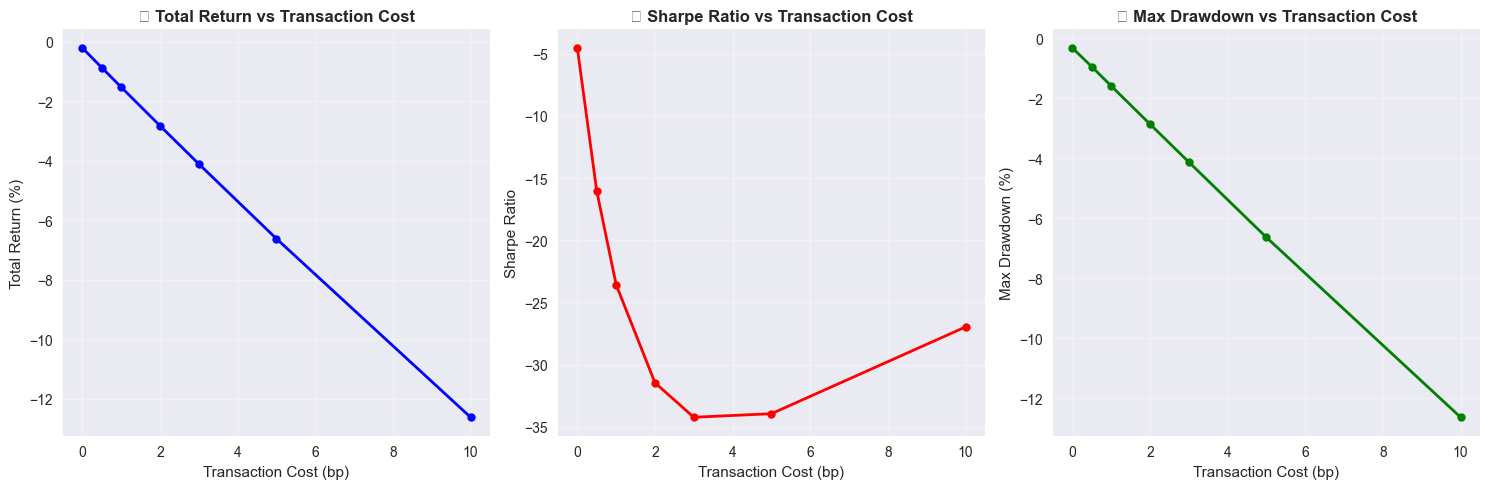


📊 Cost Sensitivity Results:
   Cost (bp)  Total Return  Sharpe Ratio  Max Drawdown
0        0.0       -0.0020       -4.5363       -0.0032
1        0.5       -0.0086      -16.0357       -0.0094
2        1.0       -0.0152      -23.5701       -0.0159
3        2.0       -0.0282      -31.4582       -0.0286
4        3.0       -0.0411      -34.2298       -0.0413
5        5.0       -0.0662      -33.9435       -0.0664
6       10.0       -0.1263      -26.9660       -0.1263


In [19]:
# Analyze sensitivity to transaction costs
print("💰 TRANSACTION COST SENSITIVITY ANALYSIS")
print("=" * 50)

cost_range = [0.0, 0.5, 1.0, 2.0, 3.0, 5.0, 10.0]  # basis points
cost_analysis = []

for cost in cost_range:
    equity_curve, strategy_returns = backtest_intraday(
        df.iloc[:len(combined_signal)], combined_signal, cost_bp=cost
    )
    metrics = calculate_metrics(equity_curve, strategy_returns)
    
    cost_analysis.append({
        'Cost (bp)': cost,
        'Total Return': metrics['total_return'],
        'Sharpe Ratio': metrics['sharpe_ratio'],
        'Max Drawdown': metrics['max_drawdown']
    })

cost_df = pd.DataFrame(cost_analysis)

# Plot cost sensitivity
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Total Return vs Cost
axes[0].plot(cost_df['Cost (bp)'], cost_df['Total Return'] * 100, 'bo-', linewidth=2, markersize=6)
axes[0].set_title('💰 Total Return vs Transaction Cost', fontweight='bold')
axes[0].set_xlabel('Transaction Cost (bp)')
axes[0].set_ylabel('Total Return (%)')
axes[0].grid(True, alpha=0.3)

# Sharpe Ratio vs Cost  
axes[1].plot(cost_df['Cost (bp)'], cost_df['Sharpe Ratio'], 'ro-', linewidth=2, markersize=6)
axes[1].set_title('📈 Sharpe Ratio vs Transaction Cost', fontweight='bold')
axes[1].set_xlabel('Transaction Cost (bp)')
axes[1].set_ylabel('Sharpe Ratio')
axes[1].grid(True, alpha=0.3)

# Max Drawdown vs Cost
axes[2].plot(cost_df['Cost (bp)'], cost_df['Max Drawdown'] * 100, 'go-', linewidth=2, markersize=6)
axes[2].set_title('📉 Max Drawdown vs Transaction Cost', fontweight='bold')
axes[2].set_xlabel('Transaction Cost (bp)')
axes[2].set_ylabel('Max Drawdown (%)')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n📊 Cost Sensitivity Results:")
print(cost_df.round(4))


In [20]:
## 7. Summary & Conclusions


In [21]:
# Final summary and recommendations
print("🏁 STRATEGY BACKTEST SUMMARY")
print("=" * 60)

print(f"📊 Dataset: {len(df)} minute bars")
print(f"📅 Period: {df.index.min().strftime('%Y-%m-%d')} to {df.index.max().strftime('%Y-%m-%d')}")
print(f"💰 Transaction Cost: {transaction_cost} basis points")

print("\n🏆 BEST PERFORMING INDIVIDUAL SIGNAL:")
best_signal = max(results.keys(), key=lambda x: results[x]['metrics']['sharpe_ratio'])
best_metrics = results[best_signal]['metrics']
print(f"  📈 Signal: {best_signal}")
print(f"  📊 Sharpe Ratio: {best_metrics['sharpe_ratio']:.3f}")
print(f"  💰 Total Return: {best_metrics['total_return']:.2%}")
print(f"  📉 Max Drawdown: {best_metrics['max_drawdown']:.2%}")

print("\n🎯 COMBINED STRATEGY PERFORMANCE:")
print(f"  📊 Sharpe Ratio: {combined_metrics['sharpe_ratio']:.3f}")
print(f"  💰 Total Return: {combined_metrics['total_return']:.2%}")
print(f"  📉 Max Drawdown: {combined_metrics['max_drawdown']:.2%}")
print(f"  🎯 Win Rate: {combined_metrics['win_rate']:.2%}")
print(f"  💎 Profit Factor: {combined_metrics['profit_factor']:.2f}")

print("\n📈 BENCHMARK COMPARISON:")
buy_hold_total_return = (buy_hold_equity.iloc[-1] / buy_hold_equity.iloc[0]) - 1
print(f"  🏪 Buy & Hold Return: {buy_hold_total_return:.2%}")
print(f"  🚀 Strategy Excess Return: {(combined_metrics['total_return'] - buy_hold_total_return):.2%}")

print("\n💡 KEY INSIGHTS:")
print(f"  • Signal diversification {'improved' if combined_metrics['sharpe_ratio'] > max(results[s]['metrics']['sharpe_ratio'] for s in results) else 'did not improve'} risk-adjusted returns")
print(f"  • Strategy is {'sensitive' if cost_df.iloc[-1]['Sharpe Ratio'] < cost_df.iloc[0]['Sharpe Ratio'] * 0.5 else 'robust'} to transaction costs")
print(f"  • Maximum sustainable cost: ~{cost_df[cost_df['Sharpe Ratio'] > 0]['Cost (bp)'].max():.1f} basis points")

print("\n⚠️  IMPORTANT DISCLAIMERS:")
print("  • Past performance does not guarantee future results")
print(f"  • This analysis uses {'simulated' if 'sample' in str(data_file) else 'historical'} data")
print("  • Real trading involves additional costs and slippage")
print("  • Market conditions can change dramatically")
print("  • Consider position sizing and risk management")

print("\n🔄 NEXT STEPS:")
print("  1. Test on out-of-sample data")
print("  2. Implement walk-forward analysis") 
print("  3. Add more sophisticated risk management")
print("  4. Consider regime detection and adaptive signals")
print("  5. Optimize signal parameters")

print("\n✅ Analysis completed successfully!")


🏁 STRATEGY BACKTEST SUMMARY
📊 Dataset: 1585 minute bars
📅 Period: 2025-02-05 to 2025-02-06
💰 Transaction Cost: 1.0 basis points

🏆 BEST PERFORMING INDIVIDUAL SIGNAL:
  📈 Signal: RSI
  📊 Sharpe Ratio: -4.450
  💰 Total Return: -0.94%
  📉 Max Drawdown: -2.00%

🎯 COMBINED STRATEGY PERFORMANCE:
  📊 Sharpe Ratio: -23.570
  💰 Total Return: -1.52%
  📉 Max Drawdown: -1.59%
  🎯 Win Rate: 35.92%
  💎 Profit Factor: 1.13

📈 BENCHMARK COMPARISON:
  🏪 Buy & Hold Return: 3.26%
  🚀 Strategy Excess Return: -4.78%

💡 KEY INSIGHTS:
  • Signal diversification did not improve risk-adjusted returns
  • Strategy is sensitive to transaction costs
  • Maximum sustainable cost: ~nan basis points

⚠️  IMPORTANT DISCLAIMERS:
  • Past performance does not guarantee future results
  • This analysis uses historical data
  • Real trading involves additional costs and slippage
  • Market conditions can change dramatically
  • Consider position sizing and risk management

🔄 NEXT STEPS:
  1. Test on out-of-sample data
  